In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

In [2]:
%matplotlib inline

In [3]:
base_dir = '/home/ytakahashi/project/kaggle/PLAsTiCC'
meta_data = pd.read_csv(os.path.join(base_dir, 'data/training_set_metadata.csv'))
test_meta_data = pd.read_csv(os.path.join(base_dir, 'data/test_set_metadata.csv'))

In [4]:
targets = np.hstack([np.unique(meta_data['target']), [99]])
target_map = {j:i for i, j in enumerate(targets)}
target_ids = [target_map[i] for i in meta_data['target']]
meta_data['target_id'] = target_ids

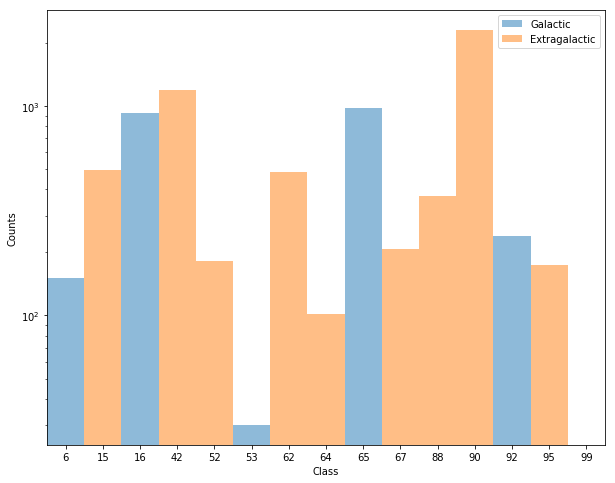

In [5]:
galactic_cut = meta_data['hostgal_specz'] == 0
plt.figure(figsize=(10, 8))
plt.hist(meta_data[galactic_cut]['target_id'], 15, (0, 15), alpha=0.5, label='Galactic')
plt.hist(meta_data[~galactic_cut]['target_id'], 15, (0, 15), alpha=0.5, label='Extragalactic')
plt.xticks(np.arange(15)+0.5, targets)
plt.gca().set_yscale("log")
plt.xlabel('Class')
plt.ylabel('Counts')
plt.xlim(0, 15)
plt.legend();

In [6]:
# Build the flat probability arrays for both the galactic and extragalactic groups
galactic_cut = meta_data['hostgal_specz'] == 0
galactic_data = meta_data[galactic_cut]
extragalactic_data = meta_data[~galactic_cut]

galactic_classes = np.unique(galactic_data['target_id'])
extragalactic_classes = np.unique(extragalactic_data['target_id'])

# Add class 99 (id=14) to both groups.
galactic_classes = np.append(galactic_classes, 14)
extragalactic_classes = np.append(extragalactic_classes, 14)

galactic_probabilities = np.zeros(15)
galactic_probabilities[galactic_classes] = 1. / len(galactic_classes)
extragalactic_probabilities = np.zeros(15)
extragalactic_probabilities[extragalactic_classes] = 1. / len(extragalactic_classes)

In [9]:
# Apply this prediction to a table
submit_df_galactic = test_meta_data[test_meta_data['hostgal_photoz']==0].loc[:,['object_id']]
for i,target_int in enumerate(targets):
    submit_df_galactic['class_%d' % target_int] = galactic_probabilities[i]
    
submit_df_extragalactic = test_meta_data[np.logical_not(test_meta_data['hostgal_photoz']==0)].loc[:,['object_id']]
for i,target_int in enumerate(targets):
    submit_df_extragalactic['class_%d' % target_int] = extragalactic_probabilities[i]
    
submit_df = pd.concat([submit_df_galactic,submit_df_extragalactic])

In [12]:
#submit_df.to_csv(os.path.join(base_dir, 'result/naive_kernel.csv'), index=False)

## Verificate naive method archives 2.156 loss

In [30]:
train_pred_galactic = meta_data[meta_data['hostgal_photoz']==0].loc[:,['object_id']]
for i, target_int in enumerate(targets):
    train_pred_galactic['class_%d' % target_int] = galactic_probabilities[i]
    
train_pred_extragalactic = meta_data[np.logical_not(meta_data['hostgal_photoz']==0)].loc[:,['object_id']]
for i, target_int in enumerate(targets):
    train_pred_extragalactic['class_%d' % target_int] = extragalactic_probabilities[i]
    
train_pred = pd.concat([train_pred_galactic, train_pred_extragalactic]).sort_index()

In [31]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
onehot = preprocessing.OneHotEncoder()
lb = preprocessing.LabelBinarizer() # this is union of le and onehot
true_df = pd.DataFrame(lb.fit_transform(meta_data.target))

In [32]:
true_df['class_99'] = 0
true_df.columns = train_pred.columns[1:]

In [33]:
from sklearn import metrics
metrics.log_loss(true_df, train_pred.iloc[:,1:])

2.1512510492560386